# Assignment 2 Part 3
Fast Gradient Sign Method for Adversarial Attacks

## Get model and load test_data

In [8]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


class SimpleCNN(nn.Module):
    # Constructor
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional Blocks (Conv -> ReLU -> Pool)
        # Block 1
        self.conv1 = nn.Conv2d(
            in_channels=3,  # 3 for RGB images
            out_channels=16,  # 16 filters
            kernel_size=3,  # 3x3 filter
            padding=1,
        )  # Keeps image size the same
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsamples by 2

        # Dropout to prevent overfitting
        self.dropout1 = nn.Dropout2d(p=0.2)

        # Block 2
        self.conv2 = nn.Conv2d(
            in_channels=16,  # Must match out_channels of conv1
            out_channels=32,
            kernel_size=3,
            padding=1,
        )
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout2 = nn.Dropout2d(p=0.2)

        self.conv3 = nn.Conv2d(
            in_channels=32,  # Must match out_channels of conv1
            out_channels=64,
            kernel_size=3,
            padding=1,
        )
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout2d(p=0.2)

        # --- Define the Classifier "Head" ---
        # This part flattens the 3D feature map to a 1D vector
        # Example calculation for 224x224 images:
        # 224 -> pool1 -> 112 -> pool2 -> 56 -> pool3 -> 28
        # So the flattened size will be: 64 (channels) * 28 (height) * 28 (width)
        # use nn.Flatten() to do this automatically

        self.flatten = nn.Flatten()

        # 64 channels * 28 H * 28 W = 50,176

        self.fc1 = nn.Linear(in_features=64 * 28 * 28, out_features=128)
        self.relu3 = nn.ReLU()

        self.dropoutfc1 = nn.Dropout(p=0.5)

        # 1 neuron for binary classification (cat vs. dog)
        self.fc2 = nn.Linear(in_features=128, out_features=1)

    # Forward Pass
    def forward(self, x):
        # 'x' is the input batch of images
        # Shape: [batch_size, 3, 224, 224]

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        # Shape is [batch_size, 16, 112, 112]

        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # Shape is [batch_size, 32, 56, 56]

        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        # Shape is [batch_size, 64, 28, 28]

        x = self.dropout3(x)

        x = self.flatten(x)
        # Shape is [batch_size, 50,176]

        x = self.fc1(x)
        x = self.relu3(x)
        # Shape is [batch_size, 128]

        x = self.dropoutfc1(x)

        x = self.fc2(x)
        # Shape is [batch_size, 1]

        return x

In [2]:
IMG_SIZE = 224
val_test_transforms = transforms.Compose(
    [
        transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        # Use the *exact* mean/std you used for training
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Define  test directory
test_dir = "/workspaces/eng-ai-agents/assignments/assignment-2/data/test"  # <--- SET THIS PATH

test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,  # Batch size doesn't matter much here
    shuffle=False,
)  # No need to shuffle


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a new, un-trained instance of the model
model = SimpleCNN().to(device)

# Load saved weights
model.load_state_dict(torch.load("best_model.pth"))

model.eval()

criterion = nn.BCEWithLogitsLoss()

/tmp/ipykernel_61324/880985598.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


## Create FGSM Attack function

In [ ]:
def fgsm_attack(model, criterion, image, label, epsilon):
    # PyTorch tracks the gradients for the *image* itself
    image.requires_grad = True

    # Get the model's output
    output = model(image)

    # Calculate the loss
    loss = criterion(output, label)

    # Zero out any old gradients
    model.zero_grad()

    # Calculate the gradient of the loss
    loss.backward()

    # Get the gradient data
    image_grad = image.grad.data

    # Get the "sign" of the gradient (the "uphill" direction)
    sign_grad = image_grad.sign()

    # Create the adversarial image by adding the "noise"
    #    (epsilon * direction) to the original image
    adv_image = image + (epsilon * sign_grad)

    return adv_image

# Replicating Attack

In [4]:
# 0.0 = no attack. 0.1 = a strong attack.
epsilon_values = [0.01, 0.05, 0.1]

for epsilon in epsilon_values:
    correct_adv = 0
    total = 0

    # Loop over the entire test set
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        labels_float = labels.float().unsqueeze(1)

        # Create the adversarial images
        adv_images = fgsm_attack(model, criterion, images, labels_float, epsilon)

        # Feed the adversarial images back into the model
        outputs = model(adv_images)

        # Check the new predictions
        preds = torch.round(torch.sigmoid(outputs))

        # Count correct predictions
        total += labels.size(0)
        correct_adv += (preds == labels_float).sum().item()

    accuracy = 100 * correct_adv / total
    print(f"Epsilon: {epsilon}  |  Adversarial Accuracy: {accuracy:.2f}%")

print(f"\nOriginal Model Accuracy: 71.00%")  # Your baseline

Epsilon: 0.01  |  Adversarial Accuracy: 42.80%
Epsilon: 0.05  |  Adversarial Accuracy: 13.00%
Epsilon: 0.1  |  Adversarial Accuracy: 6.10%

Original Model Accuracy: 71.00%


# Visualization


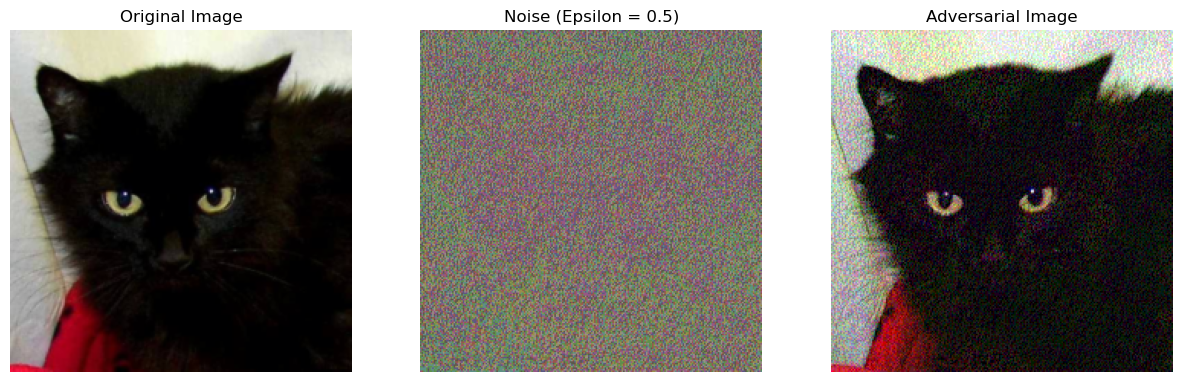

Original Prediction: 0.1340 (Cat)
Adversarial Prediction: 0.9343 (Dog)


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def unnormalize_image(tensor):
    """
    Un-normalizes a (C, H, W) tensor back to a (H, W, C)
    numpy image for plotting.
    """
    img_np = tensor.squeeze(0).cpu().detach().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img_np = img_np.transpose(1, 2, 0)
    img_unnorm = std * img_np + mean
    img_clip = np.clip(img_unnorm, 0, 1)
    return img_clip

# --- Get one image ---
data_iter = iter(test_loader)
img_orig, label_orig = next(data_iter)
img_orig, label_orig = img_orig[0:1].to(device), label_orig[0:1].to(device) # Keep batch dim
label_float = label_orig.float().unsqueeze(1)

# --- Attack the image ---
epsilon_to_plot = 0.5
img_adv = fgsm_attack(model, criterion, img_orig, label_float, epsilon_to_plot)

# --- Calculate the "noise" (perturbation) ---
noise = img_adv - img_orig

# --- Un-normalize all three for plotting ---
img_orig_plot = unnormalize_image(img_orig)
img_adv_plot = unnormalize_image(img_adv)
noise_plot = unnormalize_image(noise)

# --- Plot ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_orig_plot)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"Noise (Epsilon = {epsilon_to_plot})")
plt.imshow(noise_plot) # This will look like static
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Adversarial Image")
plt.imshow(img_adv_plot)
plt.axis("off")

plt.show()

# --- Check the model's new prediction ---
pred_orig = torch.sigmoid(model(img_orig)).item()
pred_adv = torch.sigmoid(model(img_adv)).item()

print(f"Original Prediction: {pred_orig:.4f} ({'Dog' if pred_orig > 0.5 else 'Cat'})")
print(f"Adversarial Prediction: {pred_adv:.4f} ({'Dog' if pred_adv > 0.5 else 'Cat'})")